# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). **Some users might not receive any offer during certain weeks.** 

**Not all users receive the same offer, and that is the challenge to solve with this data set.**

**Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.** This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. **You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product;** for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user **receives** as well as a record for when a user actually **views** the offer. There are also records for when a user **completes** an offer. 

Keep in mind as well that **someone using the app might make a purchase through the app without having received an offer or seen an offer.**

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, **a user can receive an offer, never actually view the offer, and still complete the offer.** For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. **You'll want to try to assess what a certain demographic group will buy when not receiving any offers.**

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a **machine learning model that predicts how much someone will spend based on demographics and offer type**. Or you could build **a model that predicts whether or not someone will respond to an offer**. Or, you don't need to build a machine learning model at all. You could develop a set of **heuristics that determine what offer you should send to each customer** (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## I. Business Understanding

Summarizing the above Introduction, we are going to:
- Combine transaction, demographic and offer data to **analyze** which demographic groups respond(i.e.view&complete) best to which offer type;
- Build a model that predicts whether or not someone will respond to an offer

## II. Data Understanding and Data Engineering

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

### 1. Portfolio Data Preprocessing

In [4]:
#create dummy columns
portfolio=portfolio.join(portfolio['channels'].str.join('|').str.get_dummies().add_prefix('channel_'))

In [5]:
portfolio=portfolio.drop('channels',axis=1)

In [6]:
#10 kinds of offers
portfolio

,difficulty,duration,id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [7]:
profile.sample(5)

,age,became_member_on,gender,id,income
11276,60,20180201,M,52734c230b984fcdb282ec42f5223dea,34000.0
4949,80,20180602,M,18f86ba6bba845f9bd35931e12122a16,112000.0
7320,93,20151010,M,8b6427bb8a2a423f92aeb27e22345449,57000.0
16656,67,20160507,F,d1de78d8698c4f9aa413feb3e8441c7d,61000.0
15242,97,20161220,F,4a7ce2339afc405dbd70ca9d07d98b97,91000.0


### 2. Profile Visualizations

In [8]:
#Age Visualization
count_by_agegroup=profile.groupby(pd.cut(profile['age'], np.arange(0, 118+5, 5)))['id'].count()

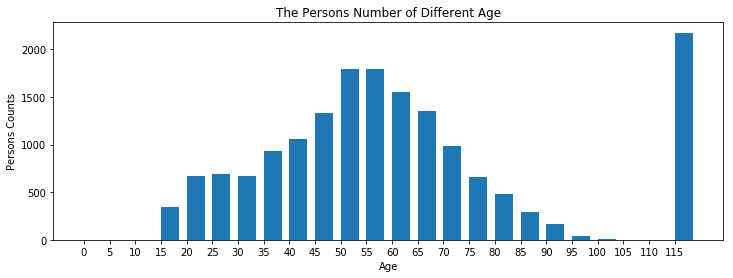

In [9]:
plt.figure(figsize=(12,4))
plt.bar(np.arange(0, 118, 5),count_by_agegroup,width=3.5, align='edge')
plt.xticks(np.arange(0, 118, 5))
plt.xlabel('Age')
plt.ylabel('Persons Counts')
plt.title('The Persons Number of Different Age')
plt.show()

In [10]:
count_by_incomegroup=profile.groupby(pd.cut(profile['income'], np.arange(20000, 120000+10000, 10000)))['id'].count()

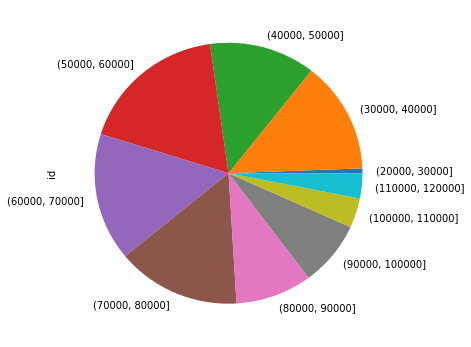

In [11]:
count_by_incomegroup.plot.pie(figsize=(6, 6))

Text(0.5,1,'The Persons Number of Different Age')

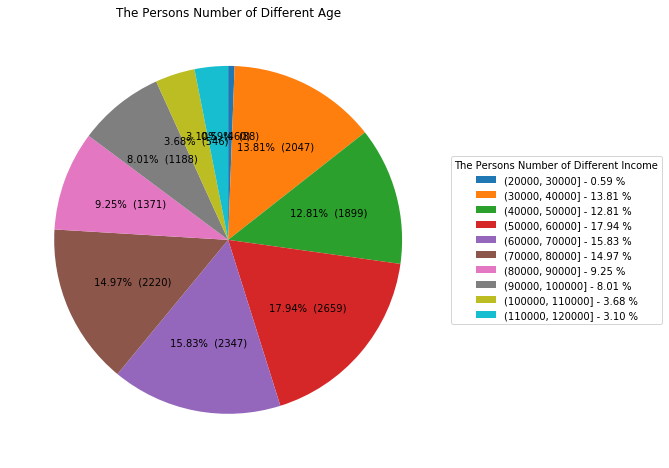

In [12]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

labels=['(20000, 30000]','(30000, 40000]','(40000, 50000]','(50000, 60000]','(60000, 70000]',\
       '(70000, 80000]','(80000, 90000]','(90000, 100000]','(100000, 110000]','(110000, 120000]']

porcent = 100.*count_by_incomegroup/count_by_incomegroup.sum()

patches, texts, autotexts = ax.pie(count_by_incomegroup, autopct=make_autopct(count_by_incomegroup),startangle=90,counterclock=False)

labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]

'''
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, count_by_incomegroup),
                                          key=lambda x: x[2],
                                          reverse=True))
'''
ax.legend(patches, labels,
          title='The Persons Number of Different Income',
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('The Persons Number of Different Age')
#plt.legend(patches, labels, loc="lower right", bbox_transform=plt.gcf().transFigure)
#plt.subplots_adjust(left=0.0, bottom=0.1, right=0.45)

**Comments:** We can see that most people have income between 50000 and 80000.

### 3. Transcript Overview

In [15]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [13]:
transcript[transcript.event=='offer received'].head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
transcript[transcript.event=='offer viewed'].head(5)

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [15]:
#Those purchased and have received an offer
transcript[transcript.event=='offer completed'].head(5)

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [16]:
#Those purchased without an offer
transcript[transcript.event=='transaction'].head(5)

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


### 4. Data Engineering 

**Tables to be Generated:**
- **transcript_new**: the transcript with offer id column name consolidated ((dup)rows are persons, columns are event, time, offer id, amount, reward)
- **person_and_offer**: transcript_new joins portfolio((dup) adding offer info to transcript_new)
- **person_offer_demographic**: person_and_offer joins parts of profile((dup) adding personal info to person_and_offer)
- **offer**: (nodup)rows are persons, columns are counts of offers received, completed, viewed&completed, noviewed&completed, received bogo,received discount, received informational, v&c_bogo, v&c_discount, v&c_discount, v&c_informational, etc.
- **offer_record**: (dup)rows are persons, columns are v&c offer id and time.
- **offer_norec_comp**: (nodup)rows are persons, columns are counts of offers completed, completed bogo, completed discount, completed informational, received&completed, noreceived&completed, nr&c_bogo, nr&c_discount, nr&c_informational, etc.
- **transaction_gen**: (nodup)rows are persons, columns are total amount of transactions(including those not completed), amount of transactions related to viewed&completed offers, amount of transactions related to noviewed&completed offers, etc. 

In [16]:
#convert dict into dummy
#transcript=pd.concat([transcript.drop(['value'], axis=1), transcript['value'].apply(pd.Series)], axis=1)

In [17]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Below are preprocessing code having run and saved as csv, **no need to run again.**

In [44]:
#it appears that those offer received and viewed have offer id in "offer id", while the offer completedc atogory have offer id in "offer_id".
#should consolidate these two columns
'''
transcript['consolidate_offer_id']=0
df_1=transcript[transcript.event=='offer received']
df_2=transcript[transcript.event=='offer viewed']
df_3=transcript[transcript.event=='offer completed']
df_4=transcript[transcript.event=='transaction']
df_1['consolidate_offer_id']=df_1['offer id']
df_2['consolidate_offer_id']=df_2['offer id']
df_3['consolidate_offer_id']=df_3['offer_id']
df_4['consolidate_offer_id']=df_4['offer_id']
transcript_new=pd.concat([df_1,df_2,df_3,df_4],axis=0)
'''

In [47]:
#save it to read next time
#transcript_new.to_csv('data/transcript_new_2.csv')

In [6]:
from tqdm import trange

Read the saved output:

In [13]:
#transcript=pd.read_csv('data/transcript_new.csv')
transcript_new=pd.read_csv('data/transcript_new_2.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
del transcript_new['Unnamed: 0']

In [15]:
del transcript_new['offer id']

In [16]:
del transcript_new['offer_id']

In [23]:
transcript_new.head()

,event,person,time,amount,reward,consolidate_offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [24]:
#Visualizing those completed the offer
amount=transcript_new[transcript_new.event=='offer completed']['amount']

In [25]:
amount.isnull().mean()

1.0

**Comments:** It seems that "offer completed" only has the offer id & reward; to see how it relates to transaction, it should join the "transactions"; or to see how is the difficulty, it should join the Portfolio table.

In [17]:
offer_completed=transcript_new[transcript_new.event=='offer completed']

In [18]:
transaction=transcript_new[transcript_new.event=='transaction']

In [19]:
#hour to day
transaction['time']=transaction['time']/24

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
transaction.rename(columns={'time':'transaction_time'}, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [21]:
portfolio.rename(columns={'id':'consolidate_offer_id'}, inplace=True)

In [22]:
#map transcript with portfolio to see details of the offer
person_and_offer=transcript_new.merge(portfolio,on='consolidate_offer_id')

In [23]:
del person_and_offer['reward_x']

In [24]:
person_and_offer.rename(columns={'reward_y':'reward'}, inplace=True)

In [25]:
person_and_offer.columns

Index(['event', 'person', 'time', 'amount', 'consolidate_offer_id',
       'difficulty', 'duration', 'offer_type', 'reward', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web'],
      dtype='object')

In [26]:
#reorder the columns
person_and_offer=person_and_offer[['event', 'person', 'consolidate_offer_id','offer_type','difficulty','amount','reward',\
                                   'duration', 'time','channel_email',\
                                       'channel_mobile', 'channel_social', 'channel_web']]

In [27]:
person_and_offer.rename(columns={'time':'offer_time'}, inplace=True)

In [28]:
#turn to days
person_and_offer['offer_time']=person_and_offer['offer_time']/24

In [23]:
person_and_offer.amount.isnull().mean()

1.0

In [30]:
#all nan in 'amount', hence can delete
del person_and_offer['amount']

In [25]:
transaction.reward.isnull().mean()

1.0

In [29]:
#all nan in 'reward', hence can delete
del transaction['reward']

In [31]:
del transaction['event']

In [43]:
transaction.consolidate_offer_id.isnull().mean()

1.0

In [32]:
#all nan in 'consolidate_offer_id', hence can delete
del transaction['consolidate_offer_id']

In [45]:
transaction.groupby('person').count().head()

,transaction_time,amount
person,,
0009655768c64bdeb2e877511632db8f,8,8
00116118485d4dfda04fdbaba9a87b5c,3,3
0011e0d4e6b944f998e987f904e8c1e5,5,5
0020c2b971eb4e9188eac86d93036a77,8,8
0020ccbbb6d84e358d3414a3ff76cffd,12,12


In [46]:
np.unique(person_and_offer.event)

array(['offer completed', 'offer received', 'offer viewed'], dtype=object)

In [47]:
person_and_offer.reward.isnull().mean()

0.0

In [33]:
#sort by person and offer_time, which may help for the following transaction merge
person_and_offer=person_and_offer.sort_values(['person','offer_time'])

In [49]:
person_and_offer[person_and_offer.person=='003d66b6608740288d6cc97a6903f4f0']

,event,person,consolidate_offer_id,offer_type,difficulty,reward,duration,offer_time,channel_email,channel_mobile,channel_social,channel_web
153521,offer received,003d66b6608740288d6cc97a6903f4f0,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,0.0,1,1,1,0
161698,offer viewed,003d66b6608740288d6cc97a6903f4f0,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,1.5,1,1,1,0
47308,offer received,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,7.0,1,1,1,1
55848,offer viewed,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,12.5,1,1,1,1
126280,offer received,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,14.0,1,1,0,1
133015,offer viewed,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,15.5,1,1,0,1
62834,offer completed,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,16.0,1,1,1,1
50246,offer received,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,17.0,1,1,1,1
57617,offer viewed,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,17.5,1,1,1,1
22514,offer received,003d66b6608740288d6cc97a6903f4f0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,10,21.0,1,0,0,1


In [50]:
transaction[transaction.person=='003d66b6608740288d6cc97a6903f4f0']

,person,transaction_time,amount
178526,003d66b6608740288d6cc97a6903f4f0,2.75,0.44
179531,003d66b6608740288d6cc97a6903f4f0,3.00,2.07
200667,003d66b6608740288d6cc97a6903f4f0,8.50,1.48
221711,003d66b6608740288d6cc97a6903f4f0,13.50,0.89
222507,003d66b6608740288d6cc97a6903f4f0,13.75,2.29
228079,003d66b6608740288d6cc97a6903f4f0,15.00,2.19
233051,003d66b6608740288d6cc97a6903f4f0,16.00,3.66
236828,003d66b6608740288d6cc97a6903f4f0,16.75,5.94
243843,003d66b6608740288d6cc97a6903f4f0,18.00,0.48
248278,003d66b6608740288d6cc97a6903f4f0,18.75,2.71


**Comment:** The above cell shows that **person_and_offer** dataframe contains the tracking of the same offer.  

For example,  
offer "5a8bc65990b245e5a138643cd4eb9837" is received and viewed;  
offer "0b1e1539f2cc45b7b9fa7c272da2e1d7" is received and completed. 

Also,  
one may received a same offer **more than once**.

In [34]:
profile.rename(columns={'id':'person'}, inplace=True)

In [35]:
#merge person&offer with profile
person_offer_demographic=person_and_offer.merge(profile[['person','age','gender','income']],on='person')

In [32]:
person_and_offer.columns

Index(['event', 'person', 'consolidate_offer_id', 'offer_type', 'difficulty',
       'reward', 'duration', 'offer_time', 'channel_email', 'channel_mobile',
       'channel_social', 'channel_web'],
      dtype='object')

In [36]:
#reorder columns
person_offer_demographic=person_offer_demographic[['event', 'person', 'age','gender','income','consolidate_offer_id', 'offer_type', 'difficulty',
       'reward', 'duration', 'offer_time', 'channel_email', 'channel_mobile',
       'channel_social', 'channel_web']]

In [34]:
person_offer_demographic.head()

,event,person,age,gender,income,consolidate_offer_id,offer_type,difficulty,reward,duration,offer_time,channel_email,channel_mobile,channel_social,channel_web
0,offer received,0009655768c64bdeb2e877511632db8f,33,M,72000.0,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,7.0,1,1,1,0
1,offer viewed,0009655768c64bdeb2e877511632db8f,33,M,72000.0,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,8.0,1,1,1,0
2,offer received,0009655768c64bdeb2e877511632db8f,33,M,72000.0,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,14.0,1,1,0,1
3,offer viewed,0009655768c64bdeb2e877511632db8f,33,M,72000.0,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,15.5,1,1,0,1
4,offer received,0009655768c64bdeb2e877511632db8f,33,M,72000.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,17.0,1,1,1,1


In [56]:
#Save and reuse
person_offer_demographic.to_csv('data/person_offer_demographic.csv')

**Comments:** In the above parts, we link person, offer and demographic information together.


However, it is tricky to figure out **how many completed offers were from offers that the person viewed beforehand** because some of the offers were completed first and then viewed afterwards; Hence, we have to separate 'viewed and completed' offers from 'completed and then viewed' ones.  

Also, we are going to calculate the transactions associated with viewed and completed vs. completed but not viewed offers because for each transaction, we don't know if it was associated with a completed offer or not.

We first conduct data engineering on offer information.

In [117]:
def offer_analyzer(person_df,person,idx,offer,offer_record):
    '''
    This function takes in a person's events from transcript df and generate a df that includes the number and type
    of offer the person received, completed, viewed and completed as well as not viewed but completed. The function 
    also generates a df of all viewed and completed offers by all users for future use.
    
    inputs:
        1. person_df - all events of this person
        2. person - the person's id
        3. idx - index to keep track of for generating 'viewed & completed offer dataframe'
        4. offer - empty offer df
        5. offer_record - empty offer_record df(if records viewed&completed offers)
    
    
    outputs:
        1. [final] - a list of all output variables including:
           receive -- counts of offer received
           comp -- counts of offer completed
           view_comp -- counts of offer viewed and completed
           noview_comp -- counts of offer completed without viewing
           bogo -- counts of viewed & completed bogo offer
           discount -- counts of viewed & completed discount offer
           informational -- counts of viewed & completed informational offer and
           10 columns for 10 types of offers-- how many times this specific offer was viewed & completed
        2. idx - updated index to keep track of for generating 'viewed & completed offer dataframe'
    '''

    # select all offers the person received
    offers = person_df[person_df.event=='offer received']
    
    # start counting
    comp = 0                   # completed offers
    view_comp = 0              # completed after view
    noview_comp = 0            # completed without view
    view_comp_offer_list = []            # keep track of offer id
    view_comp_offer_type_list = []       # keep track of offer type
    
    # loop through received offers and check if each offer was completed and/or viewed
    # 'start->end' is the time window in which an offer can be viewed & completed
    for i in range(len(offers)):
        id = offers.iloc[i]['consolidate_offer_id'] # offer id
        start = offers.iloc[i]['offer_time'] # time when this offer was received
        end = offers.iloc[i]['duration'] + start # end-point of this offer 
        
        # now check if this offer was viewed and/or completed
        viewed = 'offer viewed' in list(person_df[(person_df.offer_time>=start)&(person_df.offer_time<=end)&\
                                                  (person_df.consolidate_offer_id==id)]['event'])
        completed = 'offer completed' in list(person_df[(person_df.offer_time>=start)&(person_df.offer_time<=end)&\
                                                        (person_df.consolidate_offer_id==id)]['event'])
        
        if completed:
            comp +=1

            if viewed: 
                view_comp +=1
                view_comp_offer_list.append(id)
                view_comp_offer_type_list.append(person_df[person_df.consolidate_offer_id==id]['offer_type'].iloc[0])
                idx_time = person_df[(person_df.offer_time>=start)&(person_df.offer_time<=end)&(person_df.consolidate_offer_id==id)&\
                                     (person_df.event=='offer completed')].iloc[0]['offer_time']
                offer_record.iloc[idx] = [person,id,idx_time] # keep track of viewed & completed offers in this df
                idx +=1
            else: noview_comp +=1
           
    receive = len(offers)
    receive_bogo = list(offers.offer_type).count('bogo')
    receive_discount = list(offers.offer_type).count('discount')
    receive_informational = list(offers.offer_type).count('informational')
    bogo = view_comp_offer_type_list.count('bogo')
    discount = view_comp_offer_type_list.count('discount')
    informational = view_comp_offer_type_list.count('informational')
    
    # count how many times each type of offer was viewed & completed
    # loop through 10 different offers
    counts = []
    for off in list(portfolio.consolidate_offer_id): 
        counts.append(view_comp_offer_list.count(off))
    
    final = [receive,receive_bogo,receive_discount,receive_informational,comp,view_comp,noview_comp,bogo,discount,informational] + counts
    
    return final,idx,offer,offer_record

In [118]:
def get_offer_df(transcript):
    '''
    This function generates/modify 'offer' dataframe containing all offer history of all users, 
    and 'offer_record' dataframe containing all viewed & completed offers from all users.
    
    inputs: 
        transcript - events df
    
    outputs:
        1. offer - a dataframe containing all offer summaries of users; columns represent:
           [offers received; completed; viewed & completed; completed without viewing; viewed & completed bogo offer;
           viewed & completed discount offer; counts for each offer id (viewed and completed counts)]  
        2. offer_record - a dataframe containing records (offer id, time and person id) for all 
           viewed & completed offers
    '''


    # create empty offer and offer_record dataframes
    offer_record = pd.DataFrame(columns=['person','id','time'],index=range(len(transcript)))
    offer = pd.DataFrame(columns = ['receive','rec_bogo','rec_discount','rec_informational','comp','view_comp',
                                    'noview_comp','bogo','discount','informational',
                               'ae264e3637204a6fb9bb56bc8210ddfd','4d5c57ea9a6940dd891ad53e9dbe8da0',
                                '3f207df678b143eea3cee63160fa8bed','9b98b8c7a33c4b65b9aebfe6a799e6d9',
                               '0b1e1539f2cc45b7b9fa7c272da2e1d7','2298d6c36e964ae4a3e7e9706d1fb8c2',
                               'fafdcd668e3743c1bb461111dcafc2a4','5a8bc65990b245e5a138643cd4eb9837',
                               'f19421c1d4aa40978ebb69ca19b0e20d','2906b810c7d4411798c6938adc9daaa5']
                               ,index=list(transcript.person.unique()))
    
    persons = list(transcript.person.unique())
    idx = 0
    
    # loop through all users
    for i in trange(len(persons)):
        person=persons[i]
        person_df = transcript[transcript.person==person]

        # use above function to parse offers of a user, and save the result in offer df
        final, idx, offer, offer_record = offer_analyzer(person_df,person,idx,offer,offer_record)
        offer.loc[person] = final
        
    offer = offer.reset_index()
        
    return offer, offer_record

In [119]:
# run function and get the dataframes modified!
offer, offer_record = get_offer_df(person_offer_demographic)

# take a look at the offer df
offer.sample(5)

100%|██████████| 16994/16994 [25:16<00:00,  8.79it/s]


,index,receive,rec_bogo,rec_discount,rec_informational,comp,view_comp,noview_comp,bogo,discount,...,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
6965,68f0b93fd7cc40c0bec906c13dd2ee4b,6,3,2,1,5,3,2,2,1,...,0,2,0,0,0,1,0,0,0,0
4988,4afbf8d631374590b0eae18c659375c9,6,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2303,2423ad34c87244f9a6dba4f1d139531f,5,2,2,1,3,3,0,2,1,...,1,1,0,0,0,1,0,0,0,0
2200,2282d0c4726b4e9fad5ea8c69002ae9a,4,2,1,1,3,3,0,2,1,...,1,0,0,1,0,0,1,0,0,0
15933,f007faabf16d428cb2fde222c52ed380,5,0,2,3,2,2,0,0,2,...,0,0,0,0,0,0,1,0,0,1


In [37]:
#Save and Reuse
#offer.to_csv('data/offer.csv')
#offer_record.to_csv('data/offer_record.csv')
offer=pd.read_csv('data/offer.csv')
offer_record=pd.read_csv('data/offer_record.csv')
del offer['Unnamed: 0']
del offer_record['Unnamed: 0']
offer.rename(columns={'index':'person','bogo':'vc_bogo','discount':'vc_discount','informational':'vc_informational'}, inplace=True)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [80]:
offer.head(10)

,person,receive,rec_bogo,rec_discount,rec_informational,comp,view_comp,noview_comp,vc_bogo,vc_discount,...,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
0,0009655768c64bdeb2e877511632db8f,5,1,2,2,3,2,1,1,1,...,0,0,0,0,0,0,1,0,1,0
1,00116118485d4dfda04fdbaba9a87b5c,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0011e0d4e6b944f998e987f904e8c1e5,5,1,2,2,3,3,0,1,2,...,0,0,0,1,1,1,0,0,0,0
3,0020c2b971eb4e9188eac86d93036a77,5,2,2,1,3,2,1,1,1,...,0,1,0,0,0,0,1,0,0,0
4,0020ccbbb6d84e358d3414a3ff76cffd,4,2,1,1,3,3,0,2,1,...,0,0,0,1,0,1,0,0,1,0
5,003d66b6608740288d6cc97a6903f4f0,5,0,3,2,3,2,1,0,2,...,0,0,0,0,0,0,2,0,0,0
6,00426fe3ffde4c6b9cb9ad6d077a13ea,5,0,4,1,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
7,004b041fbfe44859945daa2c7f79ee64,3,1,1,1,2,2,0,1,1,...,0,0,0,0,0,0,1,0,1,0
8,004c5799adbf42868b9cff0396190900,5,3,2,0,5,4,1,2,2,...,0,0,0,0,0,0,2,0,2,0
9,005500a7188546ff8a767329a2f7c76a,5,4,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Below, we attempt to see whether there are offers completed without being received.  

Actually, we don't need to consider time comparison for this time, since if the offer is marked "completed", it **must** be completed in the valid time given!

In [56]:
def offer_analyzer_norec_comp(person_df,person,idx,offer,offer_record):
    '''
    This function takes in a person's events from transcript df and generate a df that includes the number and type
    of offer the person completed, received, received and completed as well as not received but completed. The function 
    also generates a df of all not received but completed offers by all users for future use.
    
    inputs:
        1. person_df - all events of this person
        2. person - the person's id
        3. idx - index to keep track of for generating 'not received & completed offer dataframe'
        4. offer - empty offer df
        5. offer_record - empty offer_record df(if records not received&completed offers)
    
    
    outputs:
        1. [final] - a list of all output variables including:
           receive -- counts of offer received
           comp -- counts of offer completed
           view_comp -- counts of offer viewed and completed
           noview_comp -- counts of offer completed without viewing
           bogo -- counts of viewed & completed bogo offer
           discount -- counts of viewed & completed discount offer
           informational -- counts of viewed & completed informational offer and
           10 columns for 10 types of offers-- how many times this specific offer was viewed & completed
        2. idx - updated index to keep track of for generating 'viewed & completed offer dataframe'
    '''

    # select all offers the person received
    comp_offers = person_df[person_df.event=='offer completed']
    
    # start counting
    rec_comp = 0                   # received&completed offers
    norec_comp = 0            # completed without received
    norec_comp_offer_list = []            # keep track of offer id
    norec_comp_offer_type_list = []       # keep track of offer type
    
    # loop through received offers and check if each offer was received/not recieved
    for i in range(len(comp_offers)):
        id = comp_offers.iloc[i]['consolidate_offer_id'] # offer id
        comp_time = comp_offers.iloc[i]['offer_time'] # time when this offer was completed

        # now check if this offer was received/not recieved
        received = 'offer received' in list(person_df[(person_df.consolidate_offer_id==id)]['event'])
        
        if received:
            rec_comp +=1

        else: 
            norec_comp +=1
            norec_comp_offer_list.append(id)
            norec_comp_offer_list.append(person_df[person_df.consolidate_offer_id==id]['offer_type'].iloc[0])
            idx_time = person_df[(person_df.consolidate_offer_id==id)&\
                                 (person_df.event=='offer completed')].iloc[0]['offer_time']
            offer_record.iloc[idx] = [person,id,idx_time] # keep track of noreceived & completed offers in this df
            idx +=1
            
    complete = len(comp_offers)
    complete_bogo = list(comp_offers.offer_type).count('bogo')
    complete_discount = list(comp_offers.offer_type).count('discount')
    complete_informational = list(comp_offers.offer_type).count('informational')
    norec_comp_bogo = norec_comp_offer_type_list.count('bogo')
    norec_comp_discount = norec_comp_offer_type_list.count('discount')
    norec_comp_informational = norec_comp_offer_type_list.count('informational')
    
    # count how many times each type of offer was viewed & completed
    # loop through 10 different offers
    counts = []
    for off in list(portfolio.consolidate_offer_id): 
        counts.append(norec_comp_offer_list.count(off))
    
    final = [complete,complete_bogo,complete_discount,complete_informational,rec_comp,norec_comp,norec_comp_bogo,norec_comp_discount,norec_comp_informational] + counts
    
    return final,idx,offer,offer_record

In [57]:
def get_offer_df_norec_comp(transcript):
    '''
    This function generates/modify 'offer' dataframe containing all offer history of all users, 
    and 'offer_record' dataframe containing all noreceived & completed offers from all users.
    
    inputs: 
        transcript - events df
    
    outputs:
        1. offer - a dataframe containing all offer summaries of users; columns represent:
           [offers received; completed; viewed & completed; completed without viewing; viewed & completed bogo offer;
           viewed & completed discount offer; counts for each offer id (viewed and completed counts)]  
        2. offer_record - a dataframe containing records (offer id, time and person id) for all 
           viewed & completed offers
    '''


    # create empty offer and offer_record dataframes
    offer_record = pd.DataFrame(columns=['person','id','time'],index=range(len(transcript)))
    offer = pd.DataFrame(columns = ['complete','complete_bogo','complete_discount','complete_informational','rec_comp','norec_comp',
                                    'norec_comp_bogo','norec_comp_discount','norec_comp_informational',
                               'ae264e3637204a6fb9bb56bc8210ddfd','4d5c57ea9a6940dd891ad53e9dbe8da0',
                                '3f207df678b143eea3cee63160fa8bed','9b98b8c7a33c4b65b9aebfe6a799e6d9',
                               '0b1e1539f2cc45b7b9fa7c272da2e1d7','2298d6c36e964ae4a3e7e9706d1fb8c2',
                               'fafdcd668e3743c1bb461111dcafc2a4','5a8bc65990b245e5a138643cd4eb9837',
                               'f19421c1d4aa40978ebb69ca19b0e20d','2906b810c7d4411798c6938adc9daaa5']
                               ,index=list(transcript.person.unique()))
    
    persons = list(transcript.person.unique())
    idx = 0
    
    # loop through all users
    for i in trange(len(persons)):
        person=persons[i]
        person_df = transcript[transcript.person==person]

        # use above function to parse offers of a user, and save the result in offer df
        final, idx, offer, offer_record = offer_analyzer_norec_comp(person_df,person,idx,offer,offer_record)
        offer.loc[person] = final
        
    offer = offer.reset_index()
        
    return offer, offer_record

In [58]:
from tqdm import trange
# run function and get the dataframes modified!
offer_norec_comp, offer_record_norec_comp = get_offer_df_norec_comp(person_offer_demographic)

# take a look at the offer df
offer_norec_comp.sample(5)

100%|██████████| 16994/16994 [11:54<00:00, 23.79it/s]


,index,complete,complete_bogo,complete_discount,complete_informational,rec_comp,norec_comp,norec_comp_bogo,norec_comp_discount,norec_comp_informational,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
7369,6eedf99e00464397b518a54ee6ebe0e6,2,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11871,b12e8e0f14ae4ad0b576f7c016e7e89b,4,1,3,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2486,26d9fdcb7d1b4b2eb60c7a65f5ba5266,5,2,3,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15300,e61d674d2adc44c59e41458f838ba954,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6649,64257cb56316491fae38e62f2687a66c,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
offer_norec_comp.to_csv('data/offer_norec_comp.csv')
offer_record_norec_comp.to_csv('data/offer_record_norec_comp.csv')

In [38]:
offer_norec_comp=pd.read_csv('data/offer_norec_comp.csv')
offer_record_norec_comp=pd.read_csv('data/offer_record_norec_comp.csv')
del offer_norec_comp['Unnamed: 0']

In [37]:
offer_record_norec_comp.isnull().mean()

Unnamed: 0    0.0
person        1.0
id            1.0
time          1.0
dtype: float64

In [63]:
offer_norec_comp['norec_comp'].mean()

0.0

**Comments:** It appears that no such offers(completed&noreceived) are in our records.

In [98]:
[1,4,5]+[1,2,3]

[1, 4, 5, 1, 2, 3]

In [82]:
print(offer_record.shape)
offer_record.isnull().mean()#less than 0.17 in the offer received, offer viewed and offer completed records are viewed&completed 

(167581, 3)


person    0.833531
id        0.833531
time      0.833531
dtype: float64

In [84]:
offer[offer['person']=='e1e614f30e9c45478d1c5aa8fe3c6dbb']

,person,receive,rec_bogo,rec_discount,rec_informational,comp,view_comp,noview_comp,vc_bogo,vc_discount,...,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
15023,e1e614f30e9c45478d1c5aa8fe3c6dbb,4,2,0,2,1,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [67]:
offer.shape

(16994, 21)

In [68]:
offer.head()

,person,receive,rec_bogo,rec_discount,rec_informational,comp,view_comp,noview_comp,vc_bogo,vc_discount,...,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
0,0009655768c64bdeb2e877511632db8f,5,1,2,2,3,2,1,1,1,...,0,0,0,0,0,0,1,0,1,0
1,00116118485d4dfda04fdbaba9a87b5c,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0011e0d4e6b944f998e987f904e8c1e5,5,1,2,2,3,3,0,1,2,...,0,0,0,1,1,1,0,0,0,0
3,0020c2b971eb4e9188eac86d93036a77,5,2,2,1,3,2,1,1,1,...,0,1,0,0,0,0,1,0,0,0
4,0020ccbbb6d84e358d3414a3ff76cffd,4,2,1,1,3,3,0,2,1,...,0,0,0,1,0,1,0,0,1,0


In [69]:
#viewed&completed offer record
offer_record.head()

,person,id,time
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.25
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,22.00
2,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,10.50
3,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,24.00
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,24.00


**Comments:** now the df "offer" can show clearly for each person,  
1.how many offers received, within which how many received bogo&discount&informational;  
2.how many offers completed, within which how many are viewed before completed and how many are completed before viewed;  
3.within view&completed, how many are bogo&discount&informational;  
4.within view&completed, the counts of each offer in the 10 choices. 


We then conduct data engineering on transaction information.

In [85]:
person_offer_demographic['offer_time'].sample()

47438    14.0
Name: offer_time, dtype: float64

In [86]:
transaction['transaction_time'].sample()

258014    20.5
Name: transaction_time, dtype: float64

In [87]:
offer_record['time'][:100].sample()

33    16.75
Name: time, dtype: float64

**Core logic of codes below:** If an offer is completed, then the transaction time should be the same as that of completed offer.  
Hence we first extract the transaction time, then see if any completed offer time of this person matches ->transaction associated with viewed and completed offers;  
Else->transaction associated with completed but not viewed offers

In [103]:
from tqdm import trange

In [100]:
def transaction_calculator(trans_ori,person,person_df,offer_record,transaction):
    '''
    This function takes in a person's events and calculate the total transaction, transaction associated
    with viewed & completed offers and transaction associated with not viewed but completed offers.
    
    inputs:
        1. trans_ori - transaction dataframe
        2. person - person id
        3. person_df - all events of the person
        4. offer_record - record of all viewed & completed offers, will be used to assess if a certain amount of 
           transaction is associated with viewed & completed offer
    
    outputs:
        1. [final] - a list including all output variables:
           total - total transaction made by this person
           view_comp - transaction associated with viewed and completed offers
           noview_comp - transaction associated with completed but not viewed offers
    '''

    # calculate total transaction made by this person
    trans = trans_ori[trans_ori['person']==person][['person','transaction_time','amount']] # all transactions
    total = trans['amount'].sum()

    # start calculating
    view_comp = 0
    noview_comp = 0 
    view = False
    comp = False
    
    # loop through transactions to see if they are associated with viewed & completed offer
    for i in range(len(trans)):
        time = trans.iloc[i]['transaction_time'] # time of this transaction
        amount = trans.iloc[i]['amount'] # amount of this transaction
        
        # check if there's any completed offer(s) at this transaction time
        comp_off = person_df[(person_df.offer_time==time)&(person_df.event=='offer completed')] # completed offers df
        
        if len(comp_off) > 0:
            comp = True

            # check if the completed offer was viewed
            # if more than one offers were completed simultaneously, check if ANY of them were viewed
            for j in range(len(comp_off)):
                if ((offer_record.person==comp_off.iloc[j]['person'])&(offer_record.id==comp_off.iloc[j]['consolidate_offer_id'])&
                (offer_record.time==comp_off.iloc[j]['offer_time'])).any(): #offer record is a df of viewed&completed offers
                    view = True
        
        # update transactions for viewed & completed offers as well as not viewed but completed offers
        if comp and view:
            view_comp += amount
        else: 
            noview_comp += amount
        
        # reset the value for next transaction 
        view = False
        comp = False
           
    final = [total,view_comp,noview_comp]
    
    return final,transaction

In [101]:
def get_transaction_df(trans_ori,transcript):
    '''
    This function generates a transaction dataframe containing all purchase behavior of all users.
    
    inputs: 
        1. trans_ori - transaction dataframe
        2. transcript - events df
        3. transaction - empty transaction df
    
    outputs:
        1. transaction_df - a dataframe contains all purchase behavior of all users including total transaction
           amount, transaction associated with viewed & compelted offers as well as transaction associated with
           not viewed but completed offers
    
    '''
    
    # create an empty transaction dataframe
    transaction = pd.DataFrame(columns = ['total','view_complete_tran','noview_complete_tran'], index=list(transcript.person.unique()))

    # loop through all users in transcript (which is also the overall users in profile)
    persons = list(transcript.person.unique())

    for i in trange(len(persons)):
        person=persons[i]
        person_df = transcript[transcript.person==person]
        
        # use above function to parse transaction and save the result in transaction df
        final,transaction = transaction_calculator(trans_ori,person,person_df,offer_record,transaction)
        transaction.loc[person] = final
        
    transaction = transaction.reset_index()
    
    return transaction

In [104]:
# run the function and get the transaction df modified!
transaction_gen = get_transaction_df(transaction,person_offer_demographic)

# take a look at the transaction df
transaction_gen.sample(5)

100%|██████████| 16994/16994 [26:42<00:00, 10.61it/s]


,index,total,view_complete_tran,noview_complete_tran
4481,4363de49f81748e8979fe15f072765b3,25.48,0,25.48
7056,6a6eace355604449a77fc84db4561f38,133.97,38.73,95.24
2327,247b5e234272439594e9b4024d7a6eea,52.09,33.98,18.11
7683,73d2f55a6c8240a2815efbe3ff95d171,134.01,49.72,84.29
4612,45546c203f724e3ba885b4e84518bca9,98.82,59.51,39.31


In [67]:
transaction_gen.to_csv('data/transaction_gen.csv')

In [39]:
transaction_gen=pd.read_csv('data/transaction_gen.csv')
del transaction_gen['Unnamed: 0']

In [39]:
transaction_gen.head()

,person,total,view_complete_tran,noview_complete_tran
0,0009655768c64bdeb2e877511632db8f,127.60,22.68,104.92
1,00116118485d4dfda04fdbaba9a87b5c,4.09,0.00,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,33.98,45.48
3,0020c2b971eb4e9188eac86d93036a77,196.86,34.87,161.99
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,36.50,117.55


### 5. Customer Behavior Analysis

#### 5.1 Customer Response Demographic Analysis

Combine customer information&offer&transaction altogether:

In [40]:
import datetime

In [41]:
person_all_information=transaction_gen.merge(profile,on='person')
person_all_information=person_all_information.merge(offer,on='person')
person_all_information['became_member_on'] = person_all_information.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d').date())
person_all_information.became_member_on=person_all_information.became_member_on.apply(lambda x: x.toordinal())

In [123]:
person_all_information.to_csv('data/person_all_information.csv')

In [42]:
person_all_information=pd.read_csv('data/person_all_information.csv')
del person_all_information['Unnamed: 0']

In [43]:
person_all_information.columns

Index(['person', 'total', 'view_complete_tran', 'noview_complete_tran', 'age',
       'became_member_on', 'gender', 'income', 'receive', 'rec_bogo',
       'rec_discount', 'rec_informational', 'comp', 'view_comp', 'noview_comp',
       'vc_bogo', 'vc_discount', 'vc_informational',
       'ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '3f207df678b143eea3cee63160fa8bed', '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7', '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4', '5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d', '2906b810c7d4411798c6938adc9daaa5'],
      dtype='object')

In [44]:
person_all_information=person_all_information[['person','age','gender','income','became_member_on','total','view_complete_tran','noview_complete_tran','receive','rec_bogo','rec_discount','rec_informational','comp','view_comp',
                                    'noview_comp','vc_bogo','vc_discount','vc_informational',
                               'ae264e3637204a6fb9bb56bc8210ddfd','4d5c57ea9a6940dd891ad53e9dbe8da0',
                                '3f207df678b143eea3cee63160fa8bed','9b98b8c7a33c4b65b9aebfe6a799e6d9',
                               '0b1e1539f2cc45b7b9fa7c272da2e1d7','2298d6c36e964ae4a3e7e9706d1fb8c2',
                               'fafdcd668e3743c1bb461111dcafc2a4','5a8bc65990b245e5a138643cd4eb9837',
                               'f19421c1d4aa40978ebb69ca19b0e20d','2906b810c7d4411798c6938adc9daaa5']]

In [165]:
person_all_information.head()

,person,age,gender,income,became_member_on,total,view_complete_tran,noview_complete_tran,receive,rec_bogo,...,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,responded
0,0009655768c64bdeb2e877511632db8f,33,2,72000.0,736440,127.60,22.68,104.92,5,1,...,0,0,0,0,0,1,0,1,0,T
1,00116118485d4dfda04fdbaba9a87b5c,118,2,NaN,736809,4.09,0.00,4.09,2,2,...,0,0,0,0,0,0,0,0,0,F
2,0011e0d4e6b944f998e987f904e8c1e5,40,2,57000.0,736703,79.46,33.98,45.48,5,1,...,0,0,1,1,1,0,0,0,0,T
3,0020c2b971eb4e9188eac86d93036a77,59,2,90000.0,736027,196.86,34.87,161.99,5,2,...,1,0,0,0,0,1,0,0,0,T
4,0020ccbbb6d84e358d3414a3ff76cffd,24,2,60000.0,736279,154.05,36.50,117.55,4,2,...,0,0,1,0,1,0,0,1,0,T


In [45]:
person_all_information['responded'] = person_all_information.view_comp.apply(lambda x: 'T' if x!=0 else 'F')

In [46]:
person_all_information['gender']=person_all_information.gender.apply(lambda x: 1 if x=='M' else (0 if x=='F' else 2))

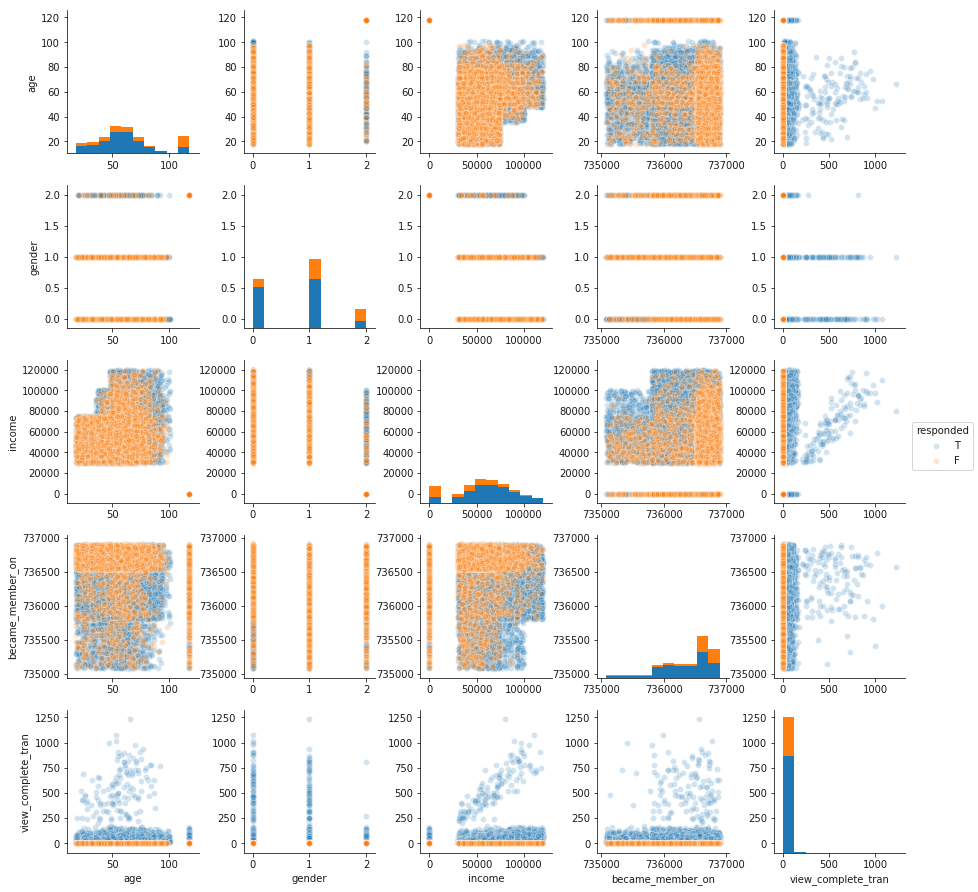

In [172]:
import warnings
warnings.filterwarnings('ignore') # turn off warning on missing values
sns.pairplot(person_all_information[['age','gender','income','became_member_on','view_complete_tran','responded']].fillna(0),hue='responded',hue_order=['T','F'],plot_kws=dict(alpha=0.2),dropna=True);

**Comments:** From the above graph, we can clearly see that the response has positive relations with age, income and became_member_on(concluded from the last row of the graph).   

Also, we can see there are orange lines in the 3 plots(age, income, became_member_on) of the last row. Those customers might be those who newly registered the mobile app and have low income.  

From the gender-gender plot, we can see that female tend to respond to offer compared with male and those input "Other" or did not input. 

Furthermore, those who didn't fully provide their personal information tend not to respond to the offer.

In [117]:
portfolio

,difficulty,duration,consolidate_offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [150]:
person_and_offer.head()

,event,person,consolidate_offer_id,offer_type,difficulty,reward,duration,offer_time,channel_email,channel_mobile,channel_social,channel_web
154797,offer received,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,7.0,1,1,1,0
162713,offer viewed,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,8.0,1,1,1,0
126294,offer received,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,14.0,1,1,0,1
132998,offer viewed,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,15.5,1,1,0,1
88222,offer received,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,17.0,1,1,1,1


In [121]:
person_all_information.head()

,person,age,gender,income,became_member_on,total,view_complete_tran,noview_complete_tran,receive,rec_bogo,...,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,responded
0,0009655768c64bdeb2e877511632db8f,33,M,72000.0,736440,127.60,22.68,104.92,5,1,...,0,0,0,0,0,1,0,1,0,T
1,00116118485d4dfda04fdbaba9a87b5c,118,None,NaN,736809,4.09,0.00,4.09,2,2,...,0,0,0,0,0,0,0,0,0,F
2,0011e0d4e6b944f998e987f904e8c1e5,40,O,57000.0,736703,79.46,33.98,45.48,5,1,...,0,0,1,1,1,0,0,0,0,T
3,0020c2b971eb4e9188eac86d93036a77,59,F,90000.0,736027,196.86,34.87,161.99,5,2,...,1,0,0,0,0,1,0,0,0,T
4,0020ccbbb6d84e358d3414a3ff76cffd,24,F,60000.0,736279,154.05,36.50,117.55,4,2,...,0,0,1,0,1,0,0,1,0,T


#### 5.2 Analysis Based on Offer Information

Next, we make analysis based on the offer information, e.g. offer type, channel, etc.

**Offer Type**

In [127]:
complete_rate=person_all_information.comp.sum()/person_all_information.receive.sum()
complete_rate

0.44090617092963802

In [147]:
bogo_complete_rate=offer_norec_comp.complete_bogo.sum()/person_all_information.rec_bogo.sum()
bogo_complete_rate

0.51375454932948617

In [148]:
discount_complete_rate=offer_norec_comp.complete_discount.sum()/person_all_information.rec_discount.sum()
discount_complete_rate

0.5863864060504862

In [149]:
informational_complete_rate=offer_norec_comp.complete_informational.sum()/person_all_information.rec_informational.sum()
informational_complete_rate

0.0

In [74]:
vc_rate=person_all_information.view_comp.sum()/person_all_information.receive.sum()
vc_rate

0.36573278970069617

In [75]:
bogo_vc_rate=person_all_information.vc_bogo.sum()/person_all_information.rec_bogo.sum()
bogo_vc_rate

0.43844060460998724

In [76]:
discount_vc_rate=person_all_information.vc_discount.sum()/person_all_information.rec_bogo.sum()
discount_vc_rate

0.47624512279091119

In [77]:
informational_vc_rate=person_all_information.vc_informational.sum()/person_all_information.rec_bogo.sum()
informational_vc_rate

0.0

From above we can see that the complete rate is about 44%, and it appears that discount offer is more preferrable than bogo and informational. Especially, for informational offer, the complete rate is 0, which shows that this type of offer might be simply providing information and hardlly inspires people to buy the products.

**Channel**

In [156]:
email_rec=person_and_offer[person_and_offer.event=='offer received'].channel_email.sum()
email_comp=person_and_offer[person_and_offer.event=='offer completed'].channel_email.sum()
email_comp/email_rec

0.4402244451145168

In [157]:
mobile_rec=person_and_offer[person_and_offer.event=='offer received'].channel_mobile.sum()
mobile_comp=person_and_offer[person_and_offer.event=='offer completed'].channel_mobile.sum()
mobile_comp/mobile_rec

0.43957789794341851

In [158]:
social_rec=person_and_offer[person_and_offer.event=='offer received'].channel_social.sum()
social_comp=person_and_offer[person_and_offer.event=='offer completed'].channel_social.sum()
social_comp/social_rec

0.47693890506315262

In [159]:
web_rec=person_and_offer[person_and_offer.event=='offer received'].channel_web.sum()
web_comp=person_and_offer[person_and_offer.event=='offer completed'].channel_web.sum()
web_comp/web_rec

0.49000836051868002

From above, it appears that web might be the most efficient channel, which contributing the highest complete rate.

## III. Data Modeling

In this part, we are going to build a machine learning model that predicts whether or not someone will respond to an offer. 

From above analysis, we know that age, gender, income, membership date, offer type can affect whether a customer respond to an offer. Hence, we make them as explanatory variable and make 'responded' as binary response variable.

In [47]:
#Import all useful packages
import datetime
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [9]:
#make the time data available to extract year&month
profile['became_member_on'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d').date())

Note that, below we are going to mark viewed&completed as responded instead of mark "completed" as responded, because the latter is actually a random behavior without **knowing** he/she has such an offer. 

In [49]:
def transform_and_tts(profile,offer):
    
    '''
    This function takes in profile and offer dataframes and returns training and test datasets for ML.
    
    inputs: 
        1. profile - profile dataframe
        2. offer - offer dataframe
    
    outputs:
        1. X_train, X_test, y_train, y_test - input data for training and test, target label for training and test
        2. age_interval, income_interval - interval index for age and income variables
    '''
    
    # transform features and label
    prof = profile.copy()
    prof = prof[prof.person.isin(list(offer[offer.receive==0]['person']))==False] # exclude people never received an offer
    prof['member_year'] = prof.became_member_on.apply(lambda x: x.year)
    prof['member_month'] = prof.became_member_on.apply(lambda x: x.month)
    prof.drop('became_member_on',axis=1,inplace=True)
    
    # create 'offer' and 'label' columns: offer col has two values (bogo or discount) and label col shows whether 
    # the user responded to the offer or not
    bogo = offer[offer.rec_bogo!=0][['person','vc_bogo']]
    bogo['label'] = bogo.vc_bogo.apply(lambda x: 0 if x==0 else 1)
    bogo.drop('vc_bogo',axis=1,inplace=True)
    bogo = prof.merge(bogo,on='person').drop('person',axis=1)
    bogo['offer'] = 'bogo'

    discount = offer[offer.rec_discount!=0][['person','vc_discount']]
    discount['label'] = discount.vc_discount.apply(lambda x: 0 if x==0 else 1)
    discount.drop('vc_discount',axis=1,inplace=True)
    discount = prof.merge(discount,on='person').drop('person',axis=1)
    discount['offer'] = 'discount'
    
    # concat bogo and discount df
    df = pd.concat([bogo,discount])
    df.age.replace(118,np.NaN,inplace=True)
    df=df.dropna()#drop nan for convenience

    # creat dummy variables
    df = pd.get_dummies(df,columns=['gender','member_year','member_month','offer'],dummy_na=True)
    
    # assign X and y
    X = df.drop('label',axis=1)
    y = df['label']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
    return X_train, X_test, y_train, y_test

In [50]:
X_train, X_test, y_train, y_test = transform_and_tts(profile,offer)

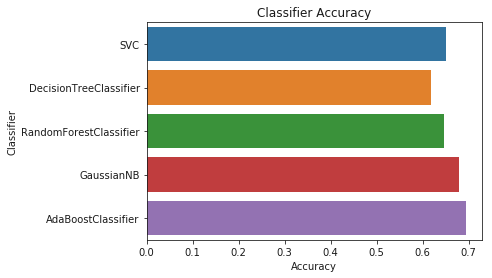

In [156]:
# Let's check out which classifier will work best in our case

classifiers = [SVC(),
                DecisionTreeClassifier(),
                RandomForestClassifier(),
                GaussianNB(),
                AdaBoostClassifier()]

X_train, X_test, y_train, y_test = transform_and_tts(profile,offer)

#scaler=MinMaxScaler()

#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.fit_transform(X_test)

performance = pd.DataFrame(columns=["Classifier", "Accuracy"])

acc_dict = {}

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    if name not in acc_dict:
        acc_dict[name] = acc
    else:
        acc_dict[name] += acc

for clf in acc_dict:
    performance_record = pd.DataFrame([[clf, acc_dict[clf]]], columns=["Classifier", "Accuracy"])
    performance = performance.append(performance_record)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.barplot(x='Accuracy', y='Classifier', data=performance);

It appears that AdaBoost is the best classifier. Therefore, we conduct GridSearch on it to find the best parameters:

In [157]:
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [5, 10, 20,50],
              "learning_rate":[0.001, 0.01, 0.1, 1],
              'base_estimator__max_depth':[1,2,3,4]
             }


DTC = DecisionTreeClassifier(random_state=42)

ADA = AdaBoostClassifier(base_estimator = DTC)

grid_ada = GridSearchCV(estimator=ADA,param_grid=param_grid,scoring='accuracy',cv=5)
grid_ada.fit(X_train,y_train)

print('Training accuracy is:', grid_ada.score(X_train,y_train))
print('Test accuracy is:', grid_ada.score(X_test,y_test))

Training accuracy is: 0.703871814503
Test accuracy is: 0.695202857872


In [159]:
#from sklearn.externals import joblib
#joblib.dump(grid_ada.best_estimator_, 'filename.pkl')

['filename.pkl']

In [53]:
from sklearn.externals import joblib
model=joblib.load('filename.pkl') 

Next, we want to make a function such that we take in customer info, offer type, etc, then we can transform all these information into format which can be taken by the classifier like the test data, then predict whether the customer respond or not based on the raw profile&offer information:

In [59]:
X_test.columns

Index(['age', 'income', 'gender_F', 'gender_M', 'gender_O', 'gender_nan',
       'member_year_2013.0', 'member_year_2014.0', 'member_year_2015.0',
       'member_year_2016.0', 'member_year_2017.0', 'member_year_2018.0',
       'member_year_nan', 'member_month_1.0', 'member_month_2.0',
       'member_month_3.0', 'member_month_4.0', 'member_month_5.0',
       'member_month_6.0', 'member_month_7.0', 'member_month_8.0',
       'member_month_9.0', 'member_month_10.0', 'member_month_11.0',
       'member_month_12.0', 'member_month_nan', 'offer_bogo', 'offer_discount',
       'offer_nan'],
      dtype='object')

In [74]:
def predict_engine(model,customer,offer_type):
    '''
    This function takes in a customers info and offer type and transform it to the same format as test data, then returns a 
    predicted result(respond or not).
    
    inputs: 
    1. model - the best classifier
    2. customer - customer's info, the same format as original profile df
    3. offer_type - 'bogo' or 'discount'
    
    outputs:
    prediction - whether the customer would respond to given offer or not

    '''
    
    # First, let's check whether the customer provided demographic info or not
    if customer['age']==118 or customer.isnull().any(): 
        flag = False
    else: 
        flag = True
    

    # Creat new customer df and tranform datetime col
    cols = transform_and_tts(profile,offer)[1].columns#takes the X_test
    customer_df = pd.DataFrame(columns=cols,index=[0])
    year = customer['became_member_on'].year
    month = customer['became_member_on'].month

    customer_df['member_year_' + str(str(float(year)))] = 1
    customer_df['member_month_' + str(str(float(month)))] = 1
    
    if flag:
        # transform profile info if provided
        
        gender = customer['gender']
        customer_df['gender_' + str(gender)] = 1
        customer_df['age']=customer['age']
        customer_df['income']=customer['income']
        customer_df['offer_' + offer_type] = 1
     
    else:
        customer_df['gender_nan'] = 1
        customer_df['offer_' + offer_type] = 1

    
    customer_df.fillna(0,inplace=True)
    
    pred = model.predict(customer_df)[0]
    
    if pred==0: 
        print('Not respond!')
    else: 
        print('Respond!')    
        
    return customer_df

In [88]:
predict_engine(model, profile.sample(1).iloc[0], 'bogo') 

Respond!


,age,income,gender_F,gender_M,gender_O,gender_nan,member_year_2013.0,member_year_2014.0,member_year_2015.0,member_year_2016.0,...,member_month_7.0,member_month_8.0,member_month_9.0,member_month_10.0,member_month_11.0,member_month_12.0,member_month_nan,offer_bogo,offer_discount,offer_nan
0,68,69000.0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


In [86]:
predict_engine(model, profile.sample(1).iloc[0], 'discount') 

Not respond!


,age,income,gender_F,gender_M,gender_O,gender_nan,member_year_2013.0,member_year_2014.0,member_year_2015.0,member_year_2016.0,...,member_month_7.0,member_month_8.0,member_month_9.0,member_month_10.0,member_month_11.0,member_month_12.0,member_month_nan,offer_bogo,offer_discount,offer_nan
0,34,34000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## IV. Evaluation of Results

To conclude, in this notebook, we:
- Cleanse the offer data such that we can separate the completed offer data into A.viewed&completed offer and B.noviewed&completed offer. The reason to do this is that even though the customers made the transaction and completed the offer, he/she may not be aware of the offer. In other words, his/her action may not be offer-oriented, hence should not be counted as **responded** to the offer;
- Cleanse the offer data such that we can separate the completed offer data into A.received&completed offer and B.noreceived&completed offer to see whether there is anyone who completed the offer without actually receiving the offer. However, it appears that there is no record for **noreceived&completed** offer in our case/data;
- Compare the transaction time and the offer completed time in order to determine whether the transaction is associated with a completed offer(more specifically, viewed&completed offer or noviewed&completed offer or other offer), because in the raw data, there are only person, amounts and time given, without telling us whether it is related to any offer;
- Next, we have demographic, offer type and channel analysis on the complete rate;
- Finally, we build a machine learning model to enable the prediction of the customer's response given a customer with age, gender, income, offer type and other information.

Possible Enhancement in the Future: 
- For convenience, I drop all the NaNs; in the future, other skills can be used, such as using mean, median, etc; or just simply keep it as a value, since in the future, there will still be part of customers who won't fill in their information; 
- This is a classification model; Alternatively, regression model can be built to predict how much someone will spend(i.e. transaction) based on demographics and offer type; 
- A web app can be built such that when inputting the customer information, the prediction of response/transaction amount can be output.